# Gradient-Based Interpretability Techniques
The goal of this notebook it to illustrate three gradient-based interpretability techniques:
1. Integrated gradient
2. Saliency map
3. Guided-GradCam

These techniques can help interpret what a model is focusing on in the input for a given classification.

The image used for these examples is my handsome dog Buddy!

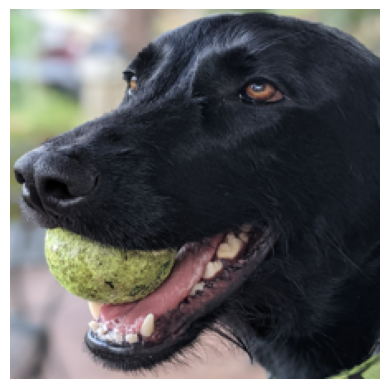

In [1]:
from captum.attr import IntegratedGradients, Saliency
import torchvision.transforms as transforms
from PIL import Image
import requests
from io import BytesIO
from matplotlib.colors import LinearSegmentedColormap
from captum.attr import visualization as viz
from captum.attr import NoiseTunnel
import numpy as np
import matplotlib.pyplot as plt

import torchvision.models as models
def load_github_image(url):
    raw_url = url.replace('github.com', 'raw.githubusercontent.com').replace('/blob/', '/')
    response = requests.get(raw_url)
    if response.status_code == 200:
        image_buffer = BytesIO(response.content)
        image = Image.open(image_buffer).convert('RGB')
        return image
    else:
        print(f"Failed to load image. Status code: {response.status_code}")
        return None

image_url = "https://github.com/ZacCarrico/imgs/blob/131f743f0d428d6c2c47871cc4cff7e0ae5d460c/dog_w_ball.jpg"
original_img = load_github_image(image_url)
# don't show axes for the image
plt.axis('off')
# plot the image as 224 x 224 pixels to match the dimensions expected by the model
plt.imshow(original_img.resize((224, 224)))

In [2]:
# these are the transforms applied to ImageNet images and applying them is critical for good model performance
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
input_tensor = transform(original_img).unsqueeze(0)

input_tensor.requires_grad_(True)
model = models.resnet34(weights='IMAGENET1K_V1')
model.eval()
model(input_tensor).topk(3)

torch.return_types.topk(
values=tensor([[11.3271, 11.0264,  9.8471]], grad_fn=<TopkBackward0>),
indices=tensor([[205, 852, 208]]))

## ImageNet class labels
205: flat-coated retriever  
852: tennis ball  
*208: Labrador retriever 

In [3]:
target_class = 208

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].


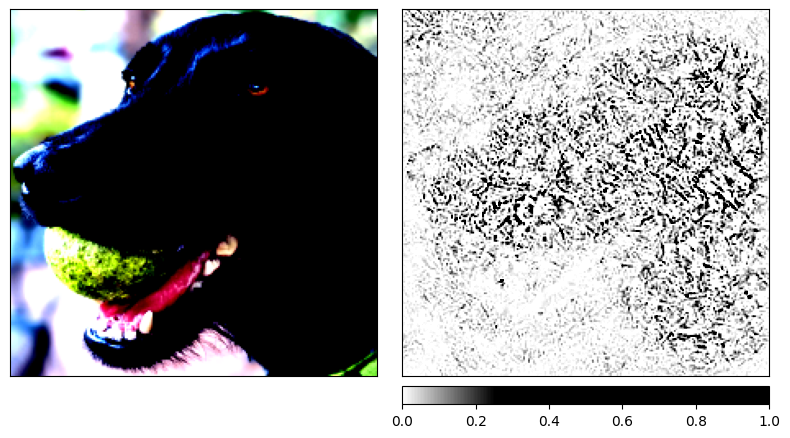

In [4]:
# Calculate integrated gradients
ig = IntegratedGradients(model)
attributions, approximation_error = ig.attribute(input_tensor, target=target_class,
                                                return_convergence_delta=True)
transposed_attr_ig = np.transpose(attributions.squeeze().detach().numpy(), (1,2,0))
transposed_image = np.transpose(input_tensor.squeeze().detach().numpy(), (1,2,0))
default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr_multiple(transposed_attr_ig,
                             transposed_image,
                             methods=["original_image", "heat_map"],
                             cmap=default_cmap,
                             show_colorbar=True,
                             signs=["all", "positive"],
                             outlier_perc=1)

In [5]:
# Noise tunnel constants
NT_SAMPLES = 20
NT_SAMPLES_BATCH_SIZE = 5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].


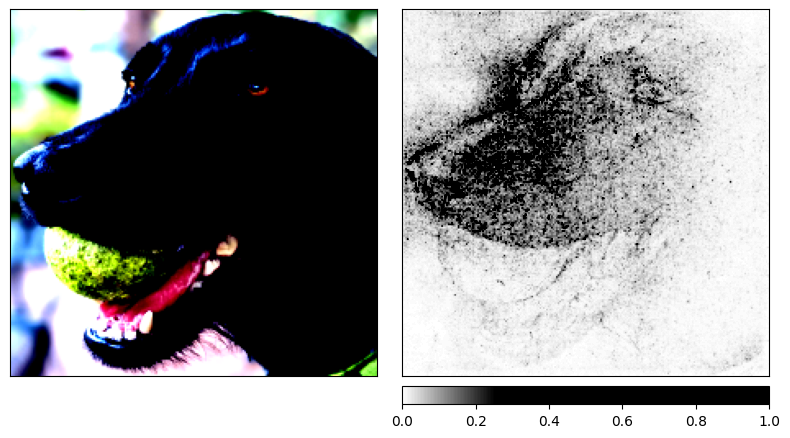

In [6]:
noise_tunnel = NoiseTunnel(ig)

attributions_ig_nt = noise_tunnel.attribute(input_tensor, nt_type='smoothgrad_sq', nt_samples_batch_size=NT_SAMPLES_BATCH_SIZE, nt_samples=NT_SAMPLES, target=target_class)
transposed_attr_ig_nt = np.transpose(attributions_ig_nt.squeeze().numpy(), (1,2,0))
_ = viz.visualize_image_attr_multiple(transposed_attr_ig_nt,
                                      transposed_image,
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].


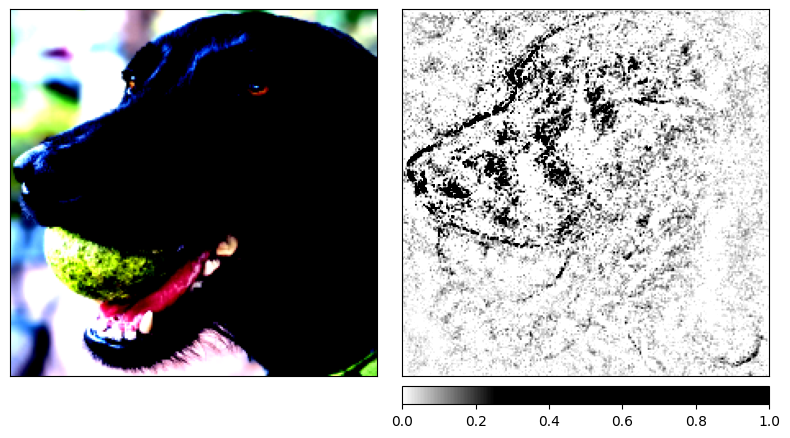

In [7]:
attributions_ig_nt = noise_tunnel.attribute(input_tensor, nt_type='smoothgrad', nt_samples_batch_size=5, nt_samples=20, target=target_class)
transposed_attr_ig_nt = np.transpose(attributions_ig_nt.squeeze().numpy(), (1,2,0))
_ = viz.visualize_image_attr_multiple(transposed_attr_ig_nt,
                                      transposed_image,
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

In [ ]:
attributions_ig_nt = noise_tunnel.attribute(input_tensor, nt_type='vargrad', nt_samples_batch_size=NT_SAMPLES_BATCH_SIZE, nt_samples=NT_SAMPLES, target=target_class)
transposed_attr_ig_nt = np.transpose(attributions_ig_nt.squeeze().numpy(), (1,2,0))
_ = viz.visualize_image_attr_multiple(transposed_attr_ig_nt,
                                      transposed_image,
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

(3, 224, 224)


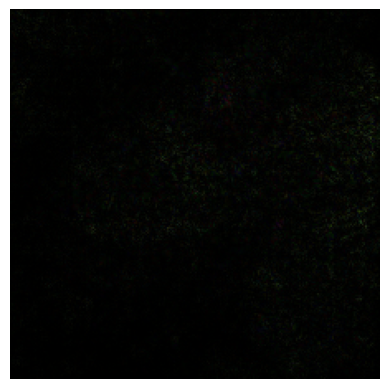

In [25]:
## Saliency Map
saliency = Saliency(model)
saliency_map = saliency.attribute(input_tensor, target_class).squeeze().numpy()
print(saliency_map.shape)
# saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())
# plt.imshow(saliency_map[0], cmap='hot')  # Select the first channel and use a colormap
plt.imshow(saliency_map.transpose(1, 2, 0), cmap='hot')
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].


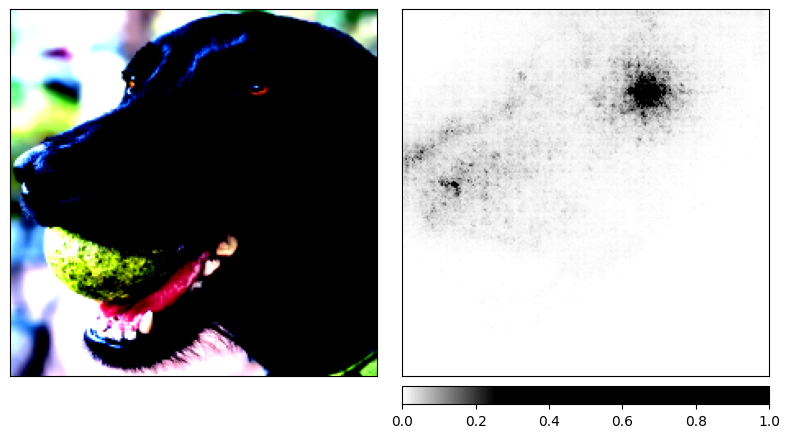

In [98]:
noise_tunnel = NoiseTunnel(saliency)
saliency_nt = noise_tunnel.attribute(input_tensor, nt_type='smoothgrad_sq', nt_samples_batch_size=NT_SAMPLES_BATCH_SIZE, nt_samples=NT_SAMPLES, target=target_class)
transposed_saliency_nt = np.transpose(saliency_nt.squeeze().numpy(), (1,2,0))
_ = viz.visualize_image_attr_multiple(transposed_saliency_nt,
                                      transposed_image,
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

/Users/zcarrico/Library/Caches/pypoetry/virtualenvs/machine-learning-dags-dMe89Gof-py3.10/lib/python3.10/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].


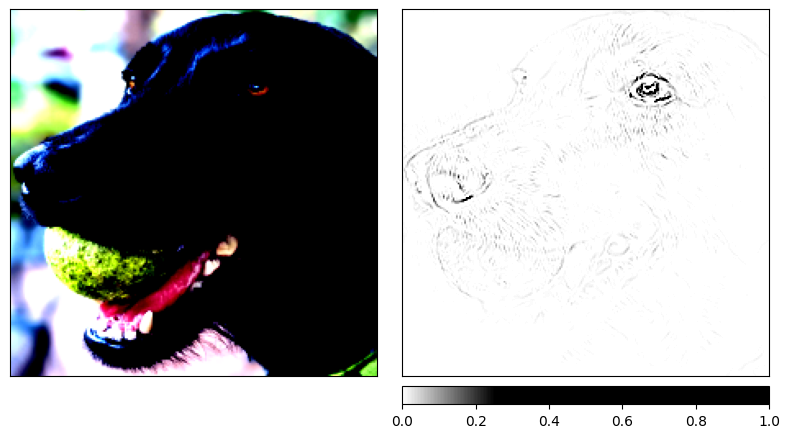

In [95]:
# use captum grad-cam to visualize the model's attention
from captum.attr import GuidedGradCam
layer_gc = GuidedGradCam(model, model.layer4)
attributions_gc = layer_gc.attribute(input_tensor, target=target_class)
transposed_attr_gc = np.transpose(attributions_gc.squeeze(0).detach().numpy(), (1,2,0))
_ = viz.visualize_image_attr_multiple(transposed_attr_gc,
                                      transposed_image,
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

/Users/zcarrico/Library/Caches/pypoetry/virtualenvs/machine-learning-dags-dMe89Gof-py3.10/lib/python3.10/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].


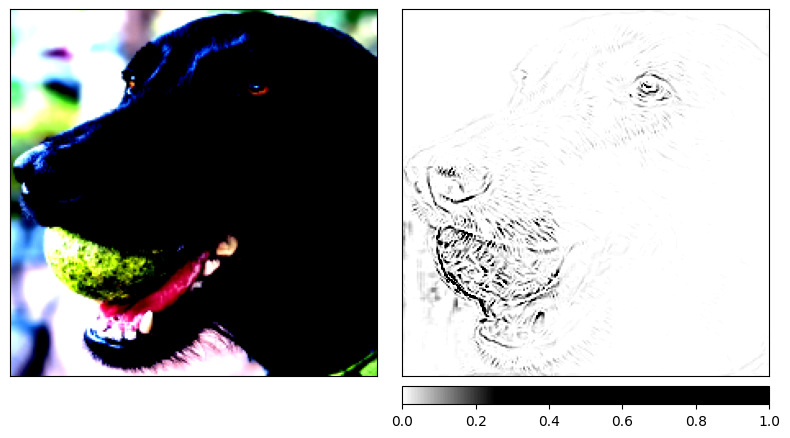

In [100]:
# use captum grad-cam to visualize the model's attention for a different class
from captum.attr import GuidedGradCam
layer_gc = GuidedGradCam(model, model.layer4)
attributions_gc = layer_gc.attribute(input_tensor, target=852)  # 852 is the class index for tennis ball
transposed_attr_gc = np.transpose(attributions_gc.squeeze(0).detach().numpy(), (1,2,0))
_ = viz.visualize_image_attr_multiple(transposed_attr_gc,
                                      transposed_image,
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)